In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pyPI as pi
import cv2

In [20]:
# Wavelength of the light source (in meters)
lambda_ = 532e-9  

# Wave number (k = 2π/λ)
k = 2 * np.pi / lambda_  

# Image resolution (pixel dimensions)
x_size = 1000  # Number of pixels in the x-axis
y_size = 500   # Number of pixels in the y-axis

# Conversion scales from pixels to meters
x_scale = lambda_ / x_size  # Pixel size in meters along x-axis
y_scale = lambda_ / y_size  # Pixel size in meters along y-axis

# Create physical coordinate grids
x_pixels = np.arange(x_size)  # X pixel indices
y_pixels = np.arange(y_size)  # Y pixel indices
X, Y = np.meshgrid(x_pixels, y_pixels)  # 2D coordinate grid
X_meters = X * x_scale  # X coordinates in meters
Y_meters = Y * y_scale  # Y coordinates in meters

# Generate combined spatial coordinate for phase modulation
x = X_meters + Y_meters

In [21]:
# Crear la imagen con intensidad de fondo 0 (sample_image)
sample_image = np.full((y_size, x_size), 0, dtype=np.uint8)

# Crear sample con la matriz identidad como fondo (debe ser complejo)
sample = np.full((y_size, x_size, 2, 2), np.eye(2, dtype=np.complex128), dtype=np.complex128)

In [22]:
grosor = 50  # Grosor de las líneas en píxeles

# Definir posiciones fijas para las líneas horizontales (en píxeles)
fixed_positions = [100, 250, 400]  # Posiciones en el eje y

# Definir intensidades específicas para cada línea en sample_image
intensity_values = [100, 180, 230]  # Valores entre 0 y 255

# Definir matrices específicas para cada línea en sample
line_matrices = [
    pi.jones_matrix(np.pi, np.pi/2),        # Línea 1
    pi.jones_matrix(np.pi/3, np.pi/3),      # Línea 2
    pi.jones_matrix(np.pi/8, np.pi/4)       # Línea 3
]

# Generar las líneas horizontales con intensidades y matrices definidas
for y_pos, intensity_value, line_matrix in zip(fixed_positions, intensity_values, line_matrices):
    sample_image[y_pos:y_pos + grosor, :] = intensity_value  # Asignar intensidad en la imagen
    sample[y_pos:y_pos + grosor, :, :] = line_matrix         # Asignar la matriz específica en sample

# Función para convertir píxeles a metros
def pixel_to_meter(x_pixel, y_pixel):
    x_meter = x_pixel * x_scale
    y_meter = y_pixel * y_scale
    return x_meter, y_meter

# Convertir posiciones de píxeles a metros
physical_positions = [pixel_to_meter(0, y) for y in fixed_positions]

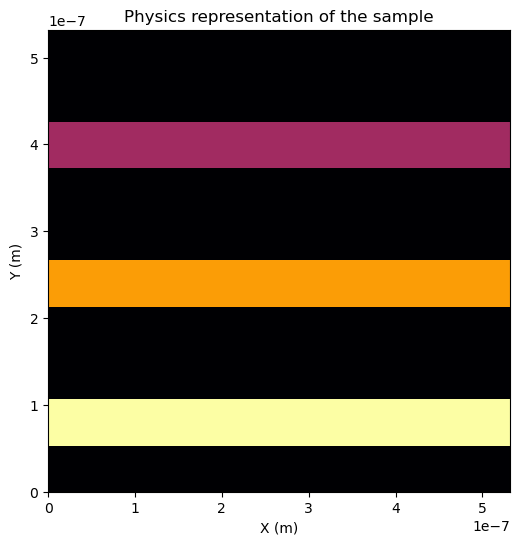

In [23]:
# Graficar el mapa de intensidad con escala en metros (sample_image)
plt.figure(figsize=(6, 6))
extent = [0, x_size * x_scale, 0, y_size * y_scale]  # Extender en unidades físicas
plt.imshow(sample_image, cmap='inferno', interpolation='nearest', extent=extent)
plt.title('Physics representation of the sample')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.show()


In [24]:
# Definir la matriz objetivo
target_matrix = line_matrices[2]

# Encontrar los píxeles donde sample tiene esta matriz
matches = np.all(sample == target_matrix, axis=(2, 3))

# Obtener las coordenadas (y, x) de los píxeles que contienen la matriz objetivo
matching_pixels = np.argwhere(matches)

# Mostrar los píxeles encontrados
sample[matching_pixels[0,0], matching_pixels[0,1]]

array([[0.96193977-0.19134172j, 0.03806023+0.19134172j],
       [0.03806023+0.19134172j, 0.96193977-0.19134172j]])

In [25]:
def create_vector_matrix(E, y_size, x_size):
    E_map = np.empty((y_size, x_size), dtype=object)
    
    for i in range(y_size):
        for j in range(x_size):
            E_map[i, j] = E.copy()
    
    return E_map

In [26]:
E_is = create_vector_matrix(np.array([[1], [1j]]), y_size, x_size)

# Crear Es con la misma forma que Eis
E_s = np.empty_like(E_is, dtype=object)

In [27]:
# Aplicar la operación elemento a elemento
for i in range(sample.shape[0]):
    for j in range(sample.shape[1]):
        E_s[i, j] = sample[i, j] @ E_is[i, j]

In [28]:
E_r = create_vector_matrix(np.array([[1], [1j]]), y_size, x_size)

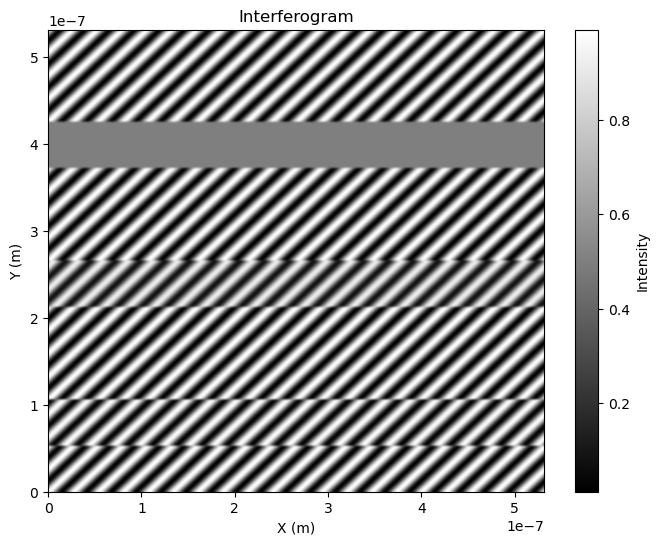

In [29]:
# Convertir E_r y E_s en arreglos NumPy de forma (M, N, 2)
E_r = np.stack([[elem.flatten() for elem in row] for row in E_r])
E_s = np.stack([[elem.flatten() for elem in row] for row in E_s])

# Ahora E_r y E_s tienen la forma correcta y se pueden operar normalmente

# Cálculo de b y m en cada píxel
b = np.sum(np.abs(E_r) ** 2, axis=-1) + np.sum(np.abs(E_s) ** 2, axis=-1)
# Cálculo de Psi utilizando np.vdot
m = np.abs(np.array([[np.vdot(E_r[i, j], E_s[i, j]) for j in range(E_r.shape[1])] 
                        for i in range(E_r.shape[0])]))


# Cálculo de la fase relativa (vartheta) en cada píxel
numerator = -np.abs(E_r[:, :, 1]) * np.abs(E_s[:, :, 1]) * np.sin(np.angle(E_r[:, :, 1]) - np.angle(E_s[:, :, 1]))
denominator = np.abs(E_r[:, :, 0]) * np.abs(E_s[:, :, 0]) + np.abs(E_r[:, :, 1]) * np.abs(E_s[:, :, 1]) * np.cos(np.angle(E_r[:, :, 1]) - np.angle(E_s[:, :, 1]))
vartheta = np.arctan2(numerator, denominator)

# Modulación de fase para cada píxel considerando X y Y en metros
franjas = 40
n = franjas / 2
mu = 0  # Desplazamiento de fase global
theta = n * (mu + k * (X_meters + Y_meters) - vartheta)
I = b + m * np.cos(theta)

# Normalizar la intensidad a escala de 0 a 255
#I_norm = ((I - I.min()) / (I.max() - I.min()) * 255).astype(np.uint8)
I_norm = (I - I.min()) / (I.max() - I.min())


# Aplicar desenfoque gaussiano para suavizar las franjas
I_blurred = cv2.GaussianBlur(I_norm, (5, 5), 0)

# Graficar el interferograma
plt.figure(figsize=(8, 6))
extent = [X_meters.min(), X_meters.max(), Y_meters.min(), Y_meters.max()]
plt.imshow(I_blurred, cmap='gray', aspect='auto', extent=extent)
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.title("Interferogram")
plt.colorbar(label="Intensity")
plt.show()

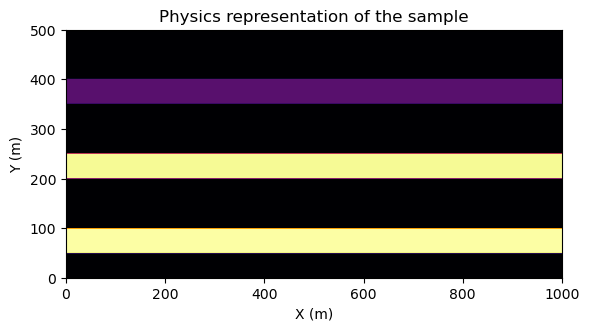

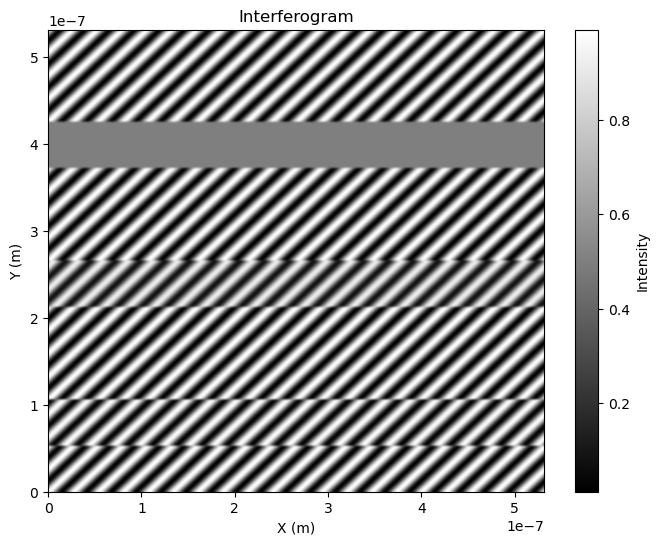

In [30]:
sample, sample_image, X, Y = pi.initialize_environment()
# Definir posiciones fijas para las líneas horizontales (en píxeles)
fixed_positions = [100, 250, 400]  # Posiciones en el eje y

# Definir matrices específicas para cada línea en sample
line_matrices = [
    pi.jones_matrix(np.pi, np.pi/2),        # Línea 1
    pi.jones_matrix(np.pi/3, np.pi/3),      # Línea 2
    pi.jones_matrix(np.pi/8, np.pi/4)       # Línea 3
]

sample = pi.add_lines(fixed_positions, line_matrices, sample_image, sample, grosor=50)

Eis = np.array([[1], [1j]])
Er = np.array([[1], [1j]])

info = pi.sample_intensity(Er, Eis, sample, X, Y)

In [31]:
import numpy as np

if np.array_equal(theta, info[2]):
    print("Los vectores son iguales en todas sus posiciones.")
else:
    print("Los vectores son diferentes.")


Los vectores son iguales en todas sus posiciones.
